## 0. Introduction 

The aim of this lab is to get familiar with **regression problems**, the concepts of **under/over-fitting**, and **regularization**. 


1.   This lab is the first course-work activity **Assignment 1 part 1: Regression (10%)**
2. The Assignment is due on **Friday , 28th October, 11:59pm**
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebook.
3. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
4. Make sure that **any figures or code** you comment on, are **included in the report**.
5. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
6. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!). 


For this lab we will use the [diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) dataset.

In [1]:
#Imports
import torch
from torch import nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

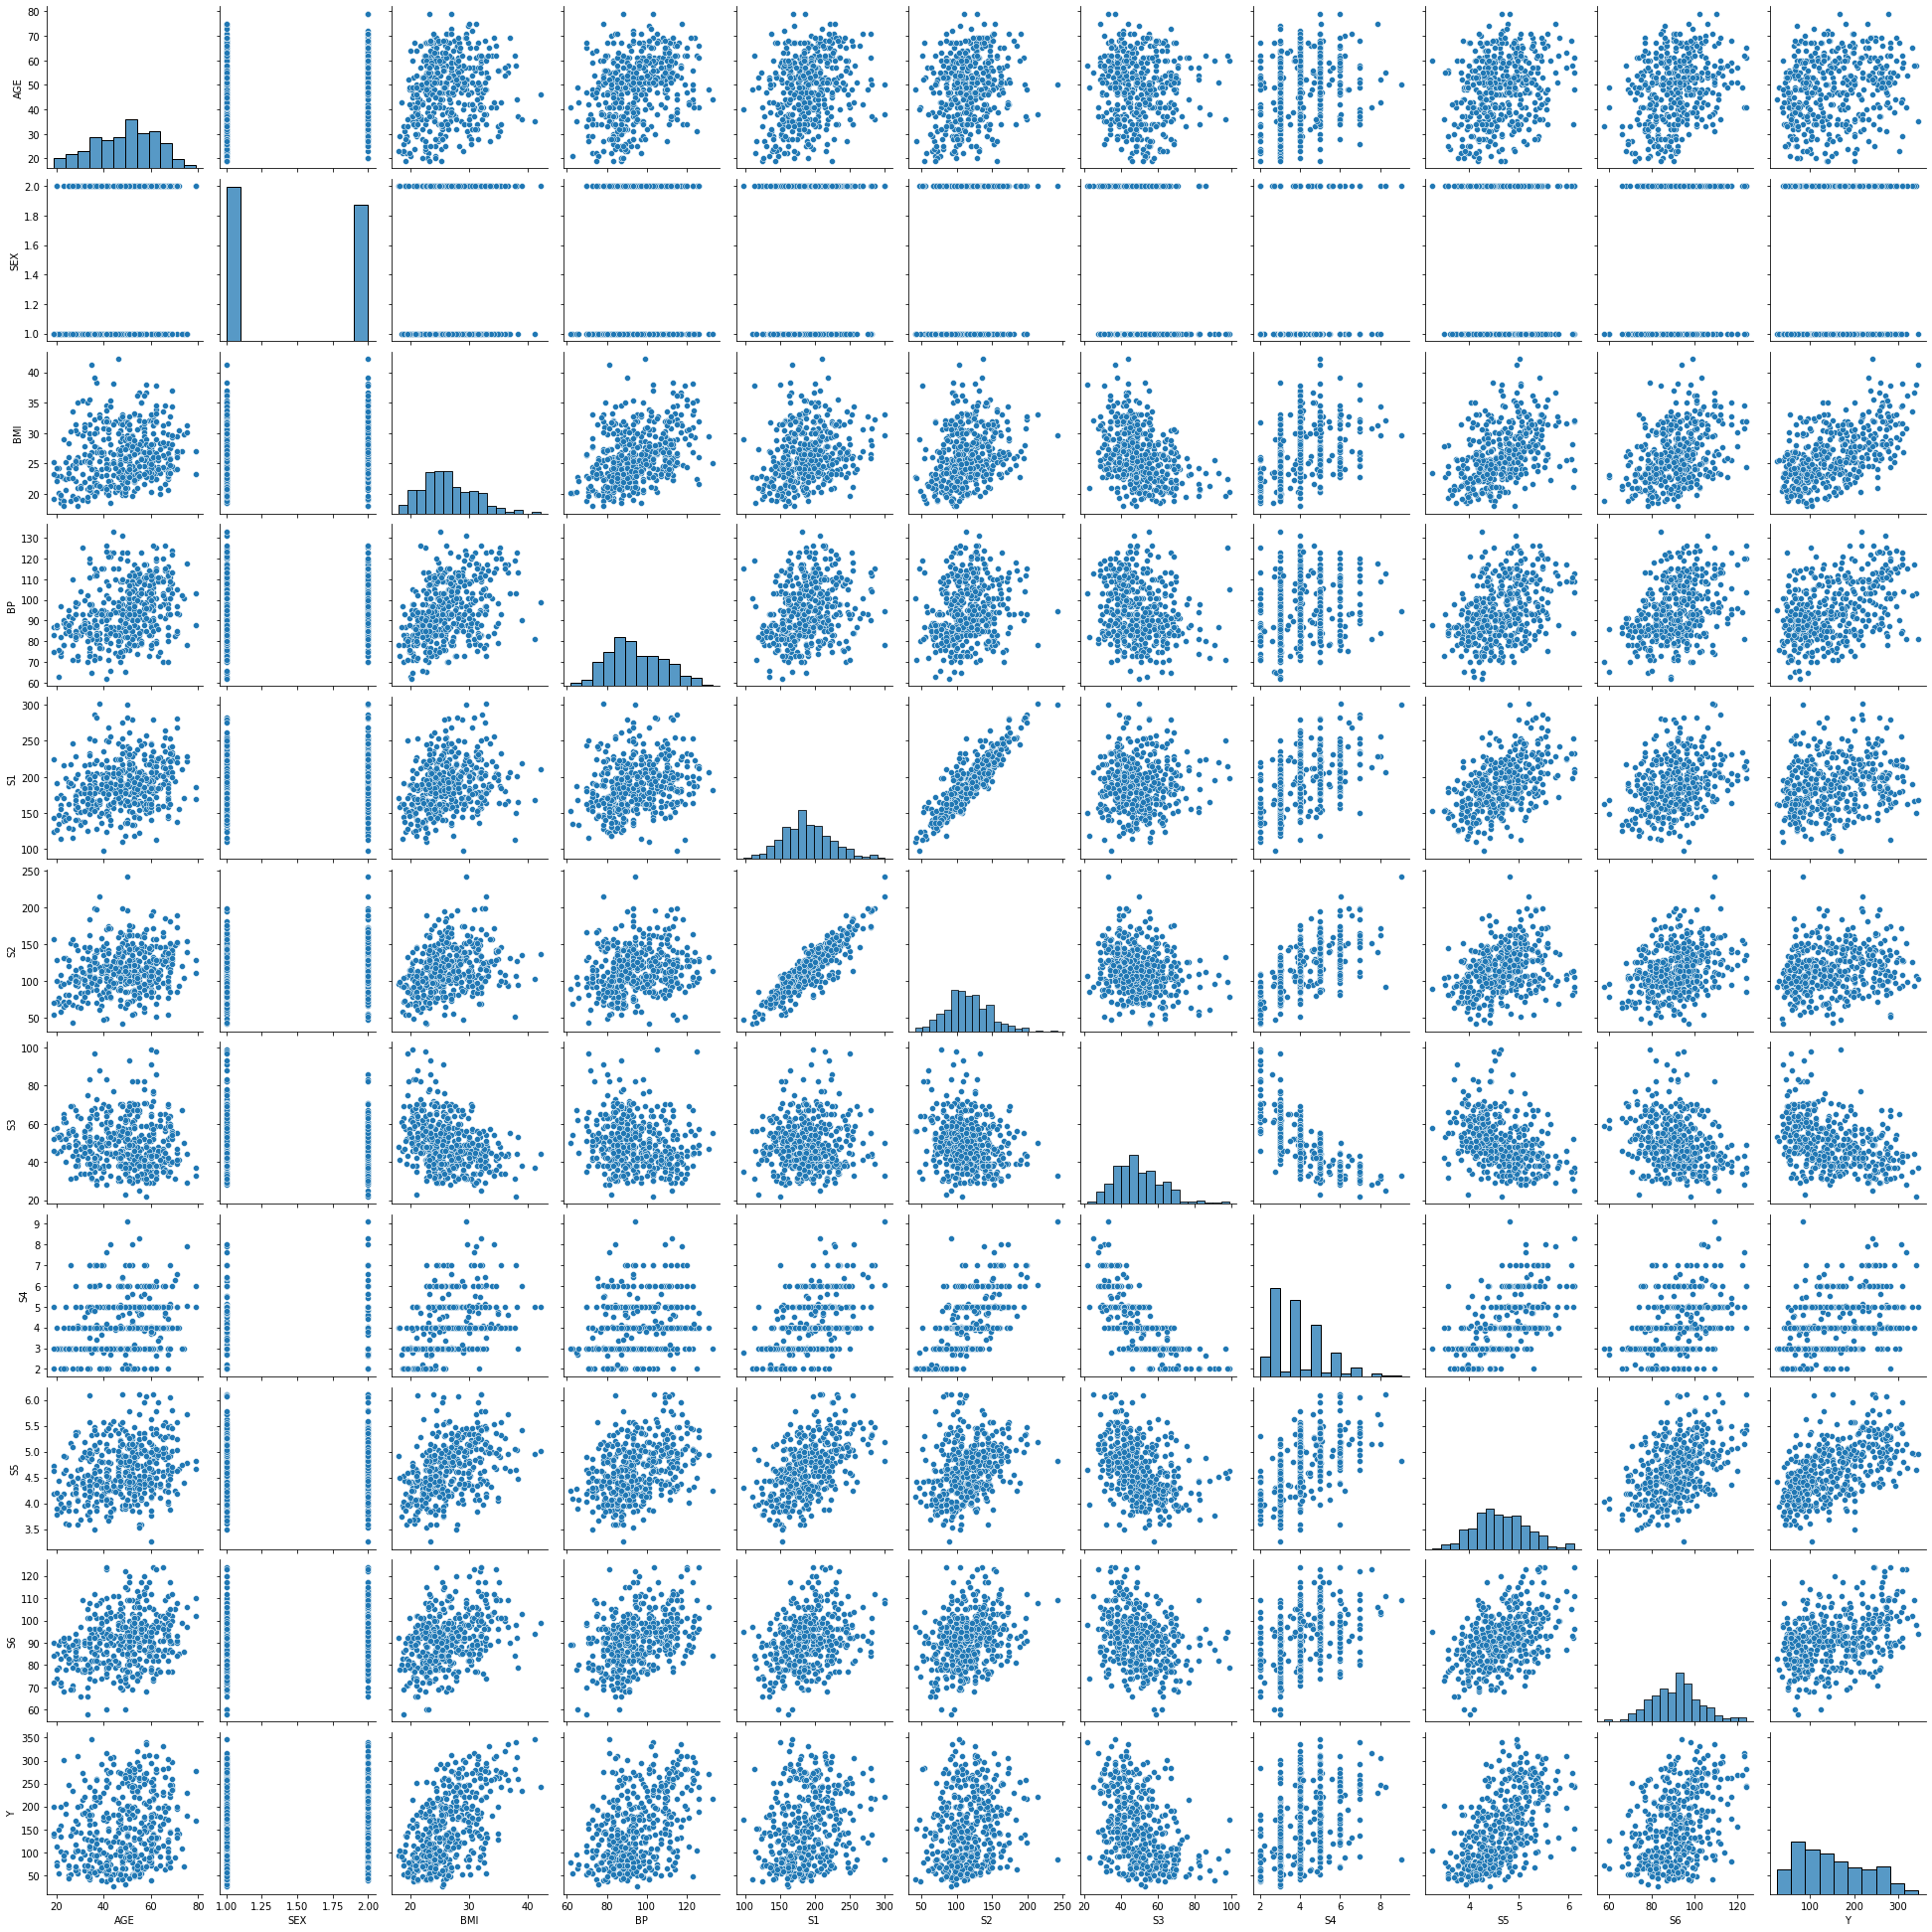

In [2]:
#Dataset 
diabetes_db = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t', header=0)
sn.pairplot(diabetes_db)

In [3]:
diabetes_db.head(10)

AGE  SEX   BMI     BP   S1     S2    S3    S4      S5  S6    Y
0   59    2  32.1  101.0  157   93.2  38.0  4.00  4.8598  87  151
1   48    1  21.6   87.0  183  103.2  70.0  3.00  3.8918  69   75
2   72    2  30.5   93.0  156   93.6  41.0  4.00  4.6728  85  141
3   24    1  25.3   84.0  198  131.4  40.0  5.00  4.8903  89  206
4   50    1  23.0  101.0  192  125.4  52.0  4.00  4.2905  80  135
5   23    1  22.6   89.0  139   64.8  61.0  2.00  4.1897  68   97
6   36    2  22.0   90.0  160   99.6  50.0  3.00  3.9512  82  138
7   66    2  26.2  114.0  255  185.0  56.0  4.55  4.2485  92   63
8   60    2  32.1   83.0  179  119.4  42.0  4.00  4.4773  94  110
9   29    1  30.0   85.0  180   93.4  43.0  4.00  5.3845  88  310

We first split the data into test and training sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [4]:
#Splitting
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    diabetes_db.loc[:, diabetes_db.columns != 'Y'],
    diabetes_db['Y'],
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).float()
y_test = y_test.reshape(-1, 1)

We can see that all the independent variables are on different scales. This can affect gradient descent, we therefore need to normalize all features to zero mean, and unit standard deviation. The normalized value $z_i$ of $x_i$ is obtained through $z_i = \frac{x_i - μ}{σ}$ where $μ$ is the mean and $σ$ is the standard deviation of $X$ and $x_i, μ, σ ∈ \mathbb{R}^D$.

**Q1.** Complete the method and normalize `x_train, x_test` [2 marks]

In [5]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  ### your code here Soumya

  z = torch.tensor
  z = (x-mu) / sigma

  return z

###your code here 
X_mean = x_train.mean(dim=0)
X_std  = x_train.std(dim=0)

x_train = norm_set(x_train, X_mean, X_std)
x_test  = norm_set(x_test, X_mean, X_std)

In [6]:
print("Normalised Values: ", x_train)

Normalised Values:  tensor([[ 1.4962,  1.0599,  0.2196,  ...,  0.7100,  0.5467, -0.0614],
        [-0.2285,  1.0599, -0.4188,  ...,  1.4822, -0.0197,  0.3667],
        [ 0.0851, -0.9408,  1.0175,  ..., -0.0621,  0.3308, -0.3182],
        ...,
        [ 0.6339, -0.9408, -0.4644,  ..., -0.8343, -0.2534, -0.0614],
        [-0.3069, -0.9408, -0.5328,  ..., -0.0621, -0.8295, -0.8319],
        [-2.0317, -0.9408,  0.5616,  ..., -0.8343, -0.1329, -0.0614]])


## 1.1 Linear Regression

We will building the linear regression model in pytorch using a custom layer. 

Refering back to the lecture notes, we define $ y = f(x) = w^T x$, so we need to learn weight vector $w$.

**Q2.** Fill in the forward method of the LinearRegression class. [2 marks]

In [7]:
class LinearRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)
  
  def forward(self, x):
    # y = 0

    ### your code here ec22353
    # w = (self.weight).T
    # y = torch.mm(x,w)

    return torch.mm(x, (self.weight).T)

As we need to account for the bias, we add a column of ones to the `x_data`

In [8]:
# add a feature for bias
x_train = torch.cat([x_train, torch.ones(x_train.shape[0], 1)], dim=1)
x_test = torch.cat([x_test, torch.ones(x_test.shape[0], 1)], dim=1)

In [9]:
## test the custom layer
model = LinearRegression(x_train.shape[1])
prediction = model(x_train)
prediction.shape # the output should be Nx1

torch.Size([353, 1])

The next step is to calculate the cost. For this we will use the mean squared error $E(w) = \frac{1}{N} Σ_{i=0}^N (f(x_i) - y_i)^2$

**Q3.** Fill in the method to calculate the squared error of for any set of labels $y$ and predictions [2 marks]

In [10]:
# def mean_squared_error(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
# your code here ec22353

def mean_squared_error(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:

  ### your code here

  cost = sum(((y_pred - y_true)**2)/len(y_pred))

  return cost

In [11]:
cost = mean_squared_error(y_train, prediction)
print("This is the initial mean suqared error value: ", cost)

This is the initial mean suqared error value:  tensor([29711.3242])


We see that using a random set of initial parameters for bias and weight, yields a relatively high error. As such, we will update the values for $w$ using gradient descent. We will implement a custom method for gradient descent.

**Q4.** In the method below, add your code to update bias and weight using learning rate $α$. [2 marks]

First you need to calculate the partial derivative of the loss function with respect to the weights. 

We then update the weights vector using the following equation:

$ weight = weight - α * ∂_{weight}$

In [12]:
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]
  
  ### your code here ec22353
  # calculate the partial derivative of the loss function with respect to w_0 and w_1

  w = 2*sum(((y_pred - y)* X))/N
  weight = weight - lr * w

  # calculate the new values for bias and weight 
  model.weight = nn.Parameter(weight, requires_grad=False)

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


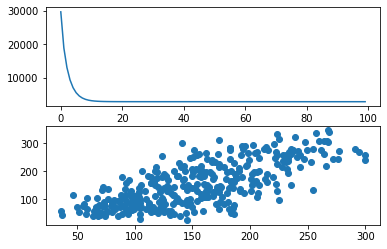

Parameter containing:
tensor([[  1.9400, -11.4488,  26.3047,  16.6306,  -9.8810,  -2.3179,  -7.6995,
           8.2121,  21.9769,   2.6065, 153.7365]])
Minimum Training cost: tensor([2890.4067])


In [13]:
#Train Value

cost_lst = list()
model = LinearRegression(x_train.shape[1])
alpha = 0.1
for it in range(100):
  prediction = model(x_train)
  cost = mean_squared_error(y_train, prediction)
  cost_lst.append(cost)
  gradient_descent_step(model, x_train, y_train, prediction, alpha)
fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst)
axs[1].scatter(prediction, y_train)
plt.show()
print(model.weight)
print('Minimum Training cost: {}'.format(min(cost_lst)))

<font color="maroon">**Q5.** What conclusion if any can be drawn from the weight values? How does gender and BMI affect blood sugar levels?

What are the estimated blood sugar levels for the below examples? [2 marks] </font>

| AGE | SEX | BMI | BP  | S1  | S2    | S3 | S4  | S5     | S6  |
|-----|-----|-----|-----|-----|-------|----|-----|--------|-----|
| 25  | F   | 18  | 79  | 130 | 64.8  | 61 | 2   | 4.1897 | 68  |
| 50  | M   | 28  | 103 | 229 | 162.2 | 60 | 4.5 | 6.107  | 124 |

In [14]:
### your code here
first_entry = torch.tensor([[25, 2, 18, 79, 130, 64.8, 61, 2, 4.1897, 68]])
second_entry = torch.tensor([[50, 1, 28, 103, 229, 162.2, 60, 4.5, 6.107, 124]])

norm_first = norm_set(first_entry, X_mean, X_std)
norm_second = norm_set(second_entry, X_mean, X_std) #Normalising the entries

ones_first = torch.cat([norm_first, torch.ones(norm_first.shape[0], 1)], dim=1)
ones_second = torch.cat([norm_second, torch.ones(norm_second.shape[0], 1)], dim=1) 

print("Prediction on the first entry: ", model(ones_first))
print("Prediction on the second entry: ", model(ones_second))

Prediction on the first entry:  tensor([[43.5294]])
Prediction on the second entry:  tensor([[232.2310]])


Now estimate the error on the test set. Is the error on the test set comparable to that of the train set? What can be said about the fit of the model? When does a model over/under fits?


In [15]:
prediction = model(x_test)
mean_squared_error(y_test, prediction)

tensor([2885.6194])

In [16]:
print('Minimum Training cost: {}'.format(min(cost_lst)))
print("This is the test Error:", mean_squared_error(y_test, prediction))

Minimum Training cost: tensor([2890.4067])
This is the test Error: tensor([2885.6194])


<font color="maroon">**Q6.** Try the code with a number of learning rates that differ by orders of magnitude and record the error of the training and test sets. What do you observe on the training error? What about the error on the test set? [3 marks]</font>

ALPHA = 0.01

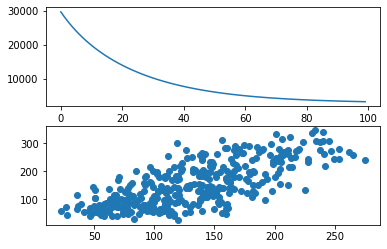

Parameter containing:
tensor([[  2.0607,  -9.1801,  23.7039,  15.3157,  -2.9941,  -5.4496, -10.2138,
           6.7962,  17.5502,   5.7594, 133.3481]])
Minimum Training cost: tensor([3356.7759])
Test Error: tensor([3431.0684])


In [17]:
### your code here
#Train Value

cost_lst = list()
model = LinearRegression(x_train.shape[1])
alpha = .01
for it in range(100):
  prediction = model(x_train)
  cost = mean_squared_error(y_train, prediction)
  cost_lst.append(cost)
  gradient_descent_step(model, x_train, y_train, prediction, alpha)
fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst)
axs[1].scatter(prediction, y_train)
plt.show()
print(model.weight)
print('Minimum Training cost: {}'.format(min(cost_lst)))

prediction = model(x_test)
print("Test Error:", mean_squared_error(y_test, prediction))

ALPHA = 0.001

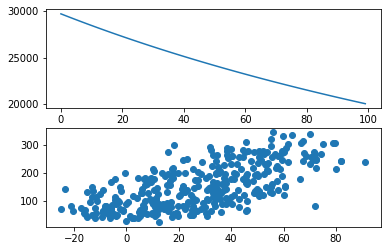

Parameter containing:
tensor([[ 1.9955, -0.5323,  7.3662,  5.3021,  1.6007,  0.9778, -4.3713,  4.4398,
          6.3970,  4.2180, 27.8929]])
Minimum Training cost: tensor([20040.5820])
Test Error: tensor([18534.3066])


In [18]:
### your code here
#Train Value

cost_lst = list()
model = LinearRegression(x_train.shape[1])
alpha = .001
for it in range(100):
  prediction = model(x_train)
  cost = mean_squared_error(y_train, prediction)
  cost_lst.append(cost)
  gradient_descent_step(model, x_train, y_train, prediction, alpha)
fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst)
axs[1].scatter(prediction, y_train)
plt.show()
print(model.weight)
print('Minimum Training cost: {}'.format(min(cost_lst)))

prediction = model(x_test)
print("Test Error:", mean_squared_error(y_test, prediction))

ALPHA = 0.0001

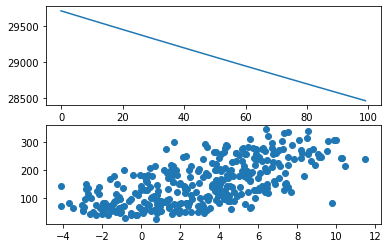

Parameter containing:
tensor([[ 2.9263e-01,  2.6794e-03,  9.1674e-01,  6.7275e-01,  2.9137e-01,
          2.2266e-01, -5.7811e-01,  6.3457e-01,  8.3265e-01,  5.8481e-01,
          3.0445e+00]])
Minimum Training cost: tensor([28468.0801])
Test Error: tensor([25530.2246])


In [19]:
### your code here
#Train Value

cost_lst = list()
model = LinearRegression(x_train.shape[1])
alpha = .0001
for it in range(100):
  prediction = model(x_train)
  cost = mean_squared_error(y_train, prediction)
  cost_lst.append(cost)
  gradient_descent_step(model, x_train, y_train, prediction, alpha)
fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst)
axs[1].scatter(prediction, y_train)
plt.show()
print(model.weight)
print('Minimum Training cost: {}'.format(min(cost_lst)))

prediction = model(x_test)
print("Test Error:", mean_squared_error(y_test, prediction))

# 1.2 Regularized Linear Regression
In this exercise, we will be trying to create a model that fits data that is clearly not linear. We will be attempting to fit the data points seen in the graph below:

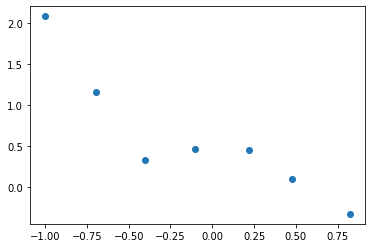

In [20]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236, 0.22024, 0.47742, 0.82229])
y = torch.tensor([2.0885, 1.1646, 0.3287, 0.46013, 0.44808, 0.10013, -0.32952]).reshape(-1, 1)
plt.scatter(x, y)
plt.show()

In order to fit this data we will create a new hypothesis function, which uses a fifth-order polynomial:

$
 h_{\theta}(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{1} ^2 + \theta_{3} x_{1} ^3 + \theta_{4} x_{1} ^4 + \theta_{5} x_{1} ^5
$

As we are fitting a small number of points with a high order model, there is a danger of overfitting.  \\

To attempt to avoid this we will use regularization. Our cost function becomes:

$
 J(\theta) = \frac{1}{2m}  \left[ \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda    \sum_{j=1}^n \theta_{j}^2 \right] 
$

Adjust variable `x` to include the higher order polynomials

In [21]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236, 0.22024, 0.47742, 0.82229]).reshape(-1, 1)
x3 = torch.cat([x, x**2, x**3, x**4, x**5, torch.ones(x.shape[0], 1)], dim=1)
print(x3)

tensor([[-9.9768e-01,  9.9537e-01, -9.9306e-01,  9.9075e-01, -9.8845e-01,
          1.0000e+00],
        [-6.9574e-01,  4.8405e-01, -3.3678e-01,  2.3431e-01, -1.6302e-01,
          1.0000e+00],
        [-4.0373e-01,  1.6300e-01, -6.5807e-02,  2.6568e-02, -1.0726e-02,
          1.0000e+00],
        [-1.0236e-01,  1.0478e-02, -1.0725e-03,  1.0978e-04, -1.1237e-05,
          1.0000e+00],
        [ 2.2024e-01,  4.8506e-02,  1.0683e-02,  2.3528e-03,  5.1818e-04,
          1.0000e+00],
        [ 4.7742e-01,  2.2793e-01,  1.0882e-01,  5.1952e-02,  2.4803e-02,
          1.0000e+00],
        [ 8.2229e-01,  6.7616e-01,  5.5600e-01,  4.5719e-01,  3.7595e-01,
          1.0000e+00]])


**Q7.** Update the cost and gradient descent methods to use the regularised cost, as shown above. [4 marks]

Note that the punishment for having more terms is not applied to the bias. This means that we use a different update technique for the partial derivative of $\theta_{0}$, and add the regularization to all of the others:



$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j=0 
$



$
 \theta_{j} =  \theta_{j} (1 - \alpha \frac{\lambda}{m}) - 
 \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j>0 
$

In [22]:
def mean_squared_error(y_true: torch.Tensor, y_pred: torch.Tensor, lam: float, theta: torch.tensor) -> torch.Tensor:
  ### your code here
  m = x.shape[0]
  # cost = sum(((y_pred - y_true)**2)/len(y_pred))
  cost_new = (1/(2*m)) * (torch.sum((y_pred-y_true)**2) + (lam * torch.sum(theta**2)))

  return cost_new

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float, lam) -> None:
  weight = model.weight
  N = X.shape[0]
  ### your code here
  ###
  call = (lr/N) * torch.sum((2*(y_pred - y))*X,dim=0)
  weight[:,0] -= call[0]
  weight[:,1:] = weight[:,1:]*(1-(lr*lam)/N) - call[1:]
  # print(weight.shape)

  model.weight = nn.Parameter(weight, requires_grad=False)

<font color="maroon"> **Q8.** First of all, find the best value of alpha to use in order to optimize best.
Next, experiment with different values of $\lambda$ and see how this affects the shape of the hypothesis. [3 marks]</font>

Best value of alpha with lambda 0

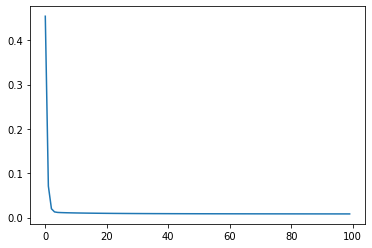

Parameter containing:
tensor([[-0.2923,  0.0906, -0.7654,  0.1418, -0.4628,  0.3817]])
Minimum cost: 0.008264507167041302


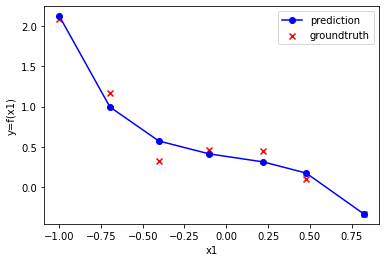

In [23]:
cost_lst = list()
model = LinearRegression(x3.shape[1])
alpha = 0.4975 # select an appropriate alpha
lam = 0.0 # select an appropriate lambda
for it in range(100):
  prediction = model(x3)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost)
  gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

Best Result of alpha and lambda

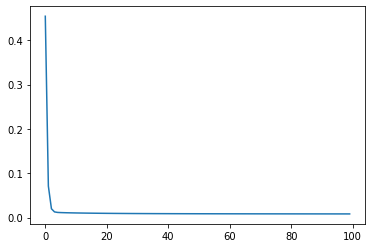

Parameter containing:
tensor([[-0.2924,  0.0906, -0.7653,  0.1418, -0.4628,  0.3816]])
Minimum cost: 0.008272412233054638


In [24]:
cost_lst = list()
model = LinearRegression(x3.shape[1])
alpha = 0.4975 # select an appropriate alpha
lam = 0.0001 # select an appropriate lambda
for it in range(100):
  prediction = model(x3)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost)
  gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

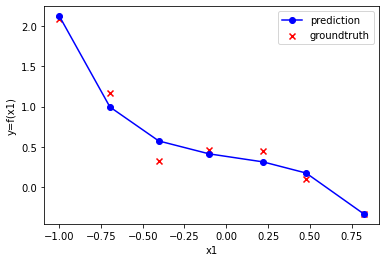

In [25]:
plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

Test trial values of best alpha and with different values of lambda.

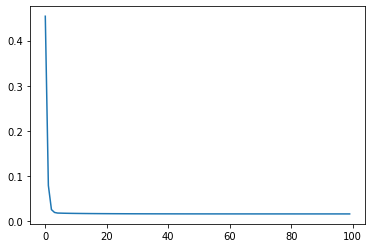

Parameter containing:
tensor([[-0.3717,  0.1064, -0.6418,  0.1674, -0.4512,  0.3729]])
Minimum cost: 0.01541689969599247


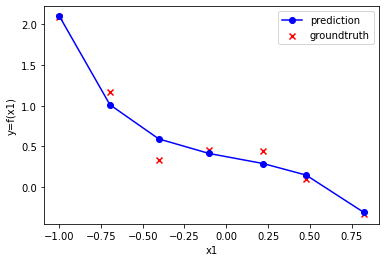

In [26]:
cost_lst = list()
model = LinearRegression(x3.shape[1])
alpha = 0.4975 # select an appropriate alpha
lam = 0.1 # select an appropriate lambda
for it in range(100):
  prediction = model(x3)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost)
  gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

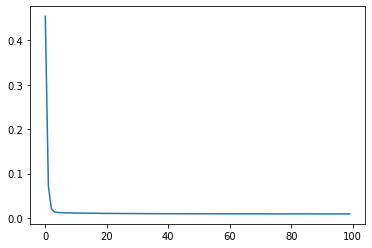

Parameter containing:
tensor([[-0.3012,  0.0922, -0.7509,  0.1449, -0.4622,  0.3807]])
Minimum cost: 0.009045101702213287


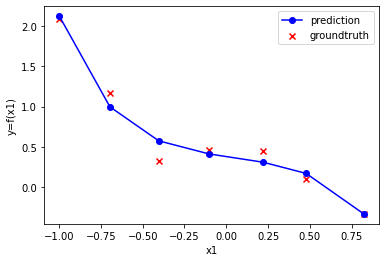

In [27]:
cost_lst = list()
model = LinearRegression(x3.shape[1])
alpha = 0.4975 # select an appropriate alpha
lam = 0.01 # select an appropriate lambda
for it in range(100):
  prediction = model(x3)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost)
  gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

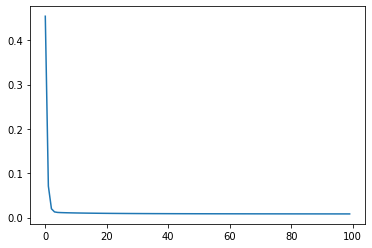

Parameter containing:
tensor([[-0.2932,  0.0908, -0.7639,  0.1421, -0.4628,  0.3816]])
Minimum cost: 0.008343462832272053


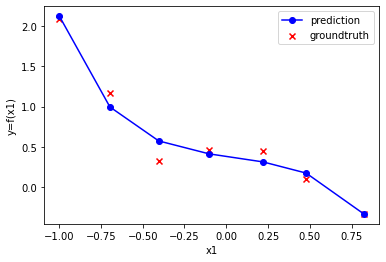

In [28]:
cost_lst = list()
model = LinearRegression(x3.shape[1])
alpha = 0.4975 # select an appropriate alpha
lam = 0.001 # select an appropriate lambda
for it in range(100):
  prediction = model(x3)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost)
  gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

Chaning alpha and Lambda value

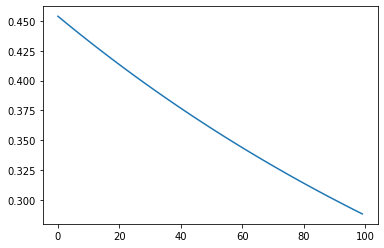

Parameter containing:
tensor([[-0.0828,  0.0628, -0.0687,  0.0554, -0.0613,  0.1047]])
Minimum cost: 0.28803515434265137


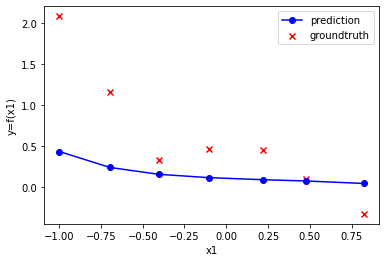

In [29]:
cost_lst = list()
model = LinearRegression(x3.shape[1])
alpha = 0.001 # select an appropriate alpha
lam = 0.01 # select an appropriate lambda
for it in range(100):
  prediction = model(x3)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost)
  gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

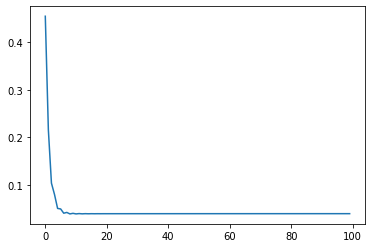

Parameter containing:
tensor([[-0.5595,  0.1528, -0.4013,  0.2049, -0.3702,  0.3517]])
Minimum cost: 0.03973077982664108


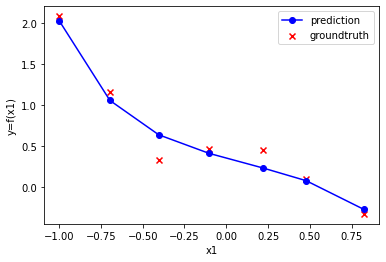

In [30]:
cost_lst = list()
model = LinearRegression(x3.shape[1])
alpha = 0.6 # select an appropriate alpha
lam = 0.5 # select an appropriate lambda
for it in range(100):
  prediction = model(x3)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost)
  gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()